In [21]:
import pandas as pd
import mne
import numpy as np

sub_01_ses_01_task_hfo_channels_tsv = pd.read_csv("..\\data\\ds003555-1.0.1\\sub-01\\ses-01\\eeg\\sub-01_ses-01_task-hfo_channels.tsv", sep="\t")
print("sub_01_ses_01_task_hfo_channels_tsv:", sub_01_ses_01_task_hfo_channels_tsv)


sub_01_ses_01_task_hfo_run_01_events_tsv = pd.read_csv("..\\data\\ds003555-1.0.1\\derivatives\\sub-01\\ses-01\\eeg\\sub-01_ses-01_task-hfo_run-01_events.tsv", sep="\t")
print("sub-01_ses_01_task-hfo_run-01_events_tsv:", sub_01_ses_01_task_hfo_run_01_events_tsv)

raw = mne.io.read_raw_edf("..\\data\\ds003555-1.0.1\\derivatives\\sub-01\\ses-01\\eeg\\sub-01_ses-01_task-hfo_run-01_eeg.edf", preload=True)
# raw = mne.io.read_raw_edf("..\\data\\ds003555-1.0.1\\sub-01\\ses-01\\eeg\\sub-01_ses-01_task-hfo_eeg.edf", preload=True)
preload=(True)

ch_labels = raw.ch_names

data = raw.get_data()

sampling_rate=raw.info['sfreq']
start_time=0
end_time=8

n_samples = data.shape[1]

start_idx = 0 if start_time is None else max(0, int(start_time * sampling_rate))
end_idx = n_samples if end_time is None else min(n_samples, int(end_time * sampling_rate))

selected_data = data[1, start_idx:end_idx]

sub_01_ses_01_task_hfo_channels_tsv:    name type units  sampling_frequency
0   Fp1  EEG    uV                1024
1    A2  EEG    uV                1024
2   Fp2  EEG    uV                1024
3    F7  EEG    uV                1024
4    F3  EEG    uV                1024
5    Fz  EEG    uV                1024
6    F4  EEG    uV                1024
7    F8  EEG    uV                1024
8    T3  EEG    uV                1024
9    C3  EEG    uV                1024
10   Cz  EEG    uV                1024
11   C4  EEG    uV                1024
12   T4  EEG    uV                1024
13   T5  EEG    uV                1024
14   P3  EEG    uV                1024
15   Pz  EEG    uV                1024
16   P4  EEG    uV                1024
17   T6  EEG    uV                1024
18   O1  EEG    uV                1024
19   A1  EEG    uV                1024
20   O2  EEG    uV                1024
21   T1  EEG    uV                1024
22   T2  EEG    uV                1024
sub-01_ses_01_task-hfo_run-

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def compute_T_GWST(z, K_max=None):
    """
    计算广义窗口傅里叶变换
    参数：
        z : 输入信号（1D数组）
        K_max : 最大k值（默认为N//2）
    返回：
        T_GWST : 时频矩阵（N x K_max）
        k_values : 使用的k值数组
    """
    N = len(z)
    K_max = K_max or N//2
    
    Z = np.fft.fft(z) / N
    
    k_values = np.arange(1, K_max+1)
    
    m = np.arange(N)[:, np.newaxis]  
    k = k_values[np.newaxis, :]      
    W = np.exp(-2 * ((m * np.pi) / k) ** 2)
    
    T_GWST = np.zeros((N, len(k_values)), dtype=np.complex128)
    
    # 计算每个k对应的GWST
    for idx, k in enumerate(k_values):
        # 循环移位Z（等效于Z(m+k)）
        shifted_Z = np.roll(Z, -k)
        
        # 应用窗口函数
        windowed_Z = shifted_Z * W[:, idx]
        
        # 计算逆FFT并缩放
        T_GWST[:, idx] = N * np.fft.ifft(windowed_Z)
    
    return T_GWST, k_values

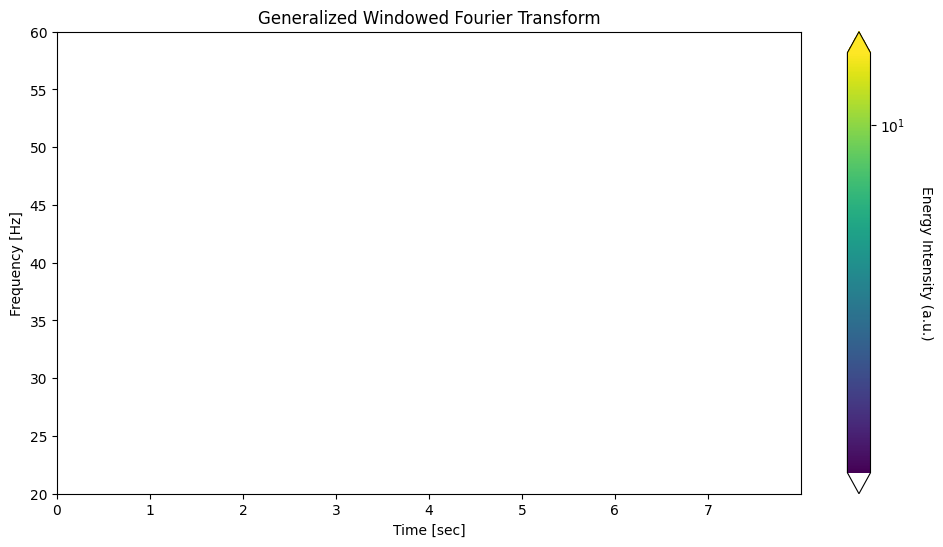

In [7]:
from matplotlib import colors


T_GWST, k_values = compute_T_GWST(selected_data, K_max=100)

# 转换为实际频率
freq = k_values * sampling_rate / len(selected_data)

time_axis = np.arange(len(selected_data)) / sampling_rate

data = np.abs(T_GWST).T

vmin = np.quantile(data, 0.05)  # 取5%分位数作为下限
vmax = np.quantile(data, 0.95)  # 取95%分位数作为上限


threshold = 10
cmap = plt.get_cmap('viridis').copy()
cmap.set_under('white')  # 设置低于vmin的颜色为白色

norm = colors.SymLogNorm(linthresh=1e-3,  # 线性区间阈值
                        linscale=0.5,    # 线性区间缩放
                        vmin=vmin,
                        vmax=vmax)

# 可视化
plt.figure(figsize=(12, 6))
pc = plt.pcolormesh(time_axis,
                freq,
                data, 
                shading='auto', 
                cmap=cmap,
                norm = norm
                )
cbar = plt.colorbar(pc, extend='both')
cbar.set_label('Energy Intensity (a.u.)', rotation=270, labelpad=20)

plt.title('Generalized Windowed Fourier Transform')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim(20, 60)
plt.show()

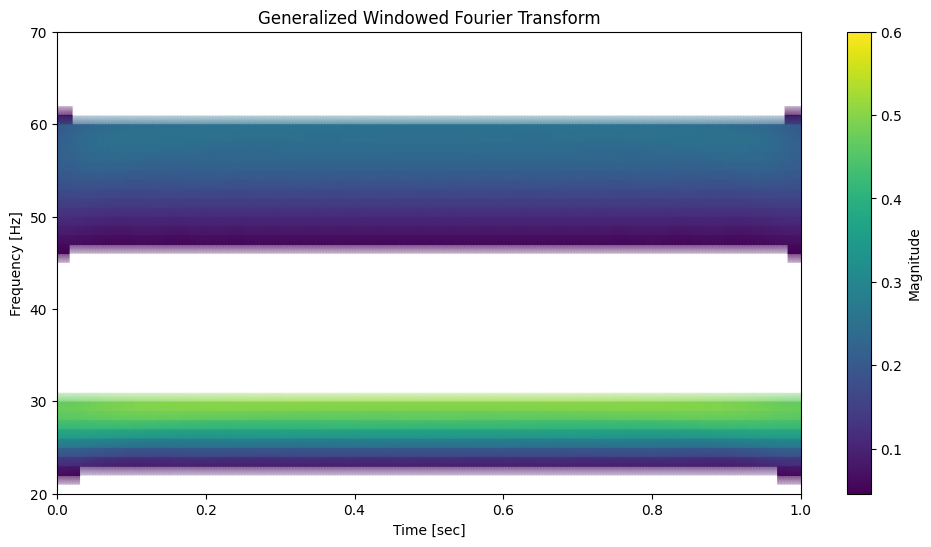

In [8]:
fs = 1000
t = np.linspace(0, 1, fs)
z = np.sin(2*np.pi*30*t) + 0.5*np.sin(2*np.pi*60*t)

# 计算变换
T_GWST, k_values = compute_T_GWST(z, K_max=100)

# 转换为实际频率
freq = k_values * fs / len(z)

demodata = np.abs(T_GWST).T

threshold = 0.1
cmap = plt.get_cmap('viridis').copy()
cmap.set_under('white')  # 设置低于vmin的颜色为白色

# 可视化
plt.figure(figsize=(12, 6))
plt.pcolormesh(t, freq, np.abs(T_GWST).T, 
              shading='gouraud', 
              cmap=cmap,
              vmin=0.6,
              vmax=np.abs(T_GWST).max()*0.1)
plt.colorbar(label='Magnitude')
plt.title('Generalized Windowed Fourier Transform')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim(20, 70)
plt.show()

In [10]:
def plot_eeg(sample, title, ch_labels, sampling_rate, start_time=None, end_time=None, target_channels=0):
    """
    Plots EEG signals over a specified time range.
    
    Parameters:
    - sample: 2D array (n_channels × n_samples) of EEG data.
    - title: Title of the plot.
    - ch_labels: List of channel names for y-axis labels.
    - sampling_rate: Sampling rate of the data (Hz) [[4]].
    - start_time: Start time (in seconds) for plotting (optional).
    - end_time: End time (in seconds) for plotting (optional).
    """
    n_samples = sample.shape[1]
    # total_time = n_samples / sampling_rate
    
    # 默认绘制全部数据
    start_idx = 0 if start_time is None else max(0, int(start_time * sampling_rate))
    end_idx = n_samples if end_time is None else min(n_samples, int(end_time * sampling_rate))
    
    # 截取指定时间范围的数据
    selected_data = sample[:, start_idx:end_idx]
    time = np.arange(start_idx, end_idx) / sampling_rate  # 生成对应的时间轴 [[2]]
    
    n_channels = selected_data.shape[0] - target_channels
    
    # 绘图
    fig, axes = plt.subplots(n_channels, 1, figsize=(12, 2 * n_channels), sharex=True)
    for i in range(n_channels):
        axes[i].plot(time, selected_data[i])
        axes[i].set_ylabel(ch_labels[i], rotation=45)
        axes[i].grid(True)
    
    axes[-1].set_xlabel('Time (s)')
    plt.suptitle(title, y=0.995)
    plt.tight_layout()
    plt.show()
    # plt.savefig("eeg_plot.png", dpi=300, bbox_inches='tight')


In [ ]:
import pandas as pd
import mne

sub_01_ses_01_task_hfo_channels_tsv = pd.read_csv("..\\data\\ds003555-1.0.1\\sub-01\\ses-01\\eeg\\sub-01_ses-01_task-hfo_channels.tsv", sep="\t")
print("sub_01_ses_01_task_hfo_channels_tsv:", sub_01_ses_01_task_hfo_channels_tsv)


sub_01_ses_01_task_hfo_run_01_events_tsv = pd.read_csv("..\\data\\ds003555-1.0.1\\derivatives\\sub-01\\ses-01\\eeg\\sub-01_ses-01_task-hfo_run-01_events.tsv", sep="\t")
print("sub-01_ses_01_task-hfo_run-01_events_tsv:", sub_01_ses_01_task_hfo_run_01_events_tsv)

raw = mne.io.read_raw_edf("..\\data\\ds003555-1.0.1\\derivatives\\sub-01\\ses-01\\eeg\\sub-01_ses-01_task-hfo_run-01_eeg.edf", preload=True)


In [ ]:
import os
from pathlib import Path
import pandas as pd
import mne  # 需要安装mne-python库读取EDF文件

# 根目录路径
root_dir = "..\\data\\ds003555-1.0.1\\derivatives"

# 存储所有数据的容器
data_dict = {}

# 遍历所有sub-*文件夹
for sub_dir in Path(root_dir).glob("sub-*"):
    sub_id = sub_dir.name  # 例如 sub-01
    
    # 读取sub-*_sessions.tsv
    sessions_tsv = sub_dir / f"{sub_id}_sessions.tsv"
    if sessions_tsv.exists():
        sessions_df = pd.read_csv(sessions_tsv, sep='\t')
        data_dict[sub_id] = {"sessions_info": sessions_df}
    else:
        data_dict[sub_id] = {}
        continue
    
    # 遍历所有ses-*文件夹
    for ses_dir in sub_dir.glob("ses-*"):
        ses_id = ses_dir.name  # 例如 ses-01
        eeg_dir = ses_dir / "eeg"
        
        if not eeg_dir.exists():
            continue
        
        # 查找所有task-hfo的EEG文件（匹配不同run）
        for eeg_file in eeg_dir.glob(f"{sub_id}_{ses_id}_task-hfo_run-*_eeg.edf"):
            # 解析run编号
            run_id = eeg_file.name.split("_")[3].split("-")[1]  # 例如 run-01 -> 01
            
            # 构建关联文件路径
            channels_tsv = eeg_dir / f"{sub_id}_{ses_id}_task-hfo_run-{run_id}_channels.tsv"
            events_tsv = eeg_dir / f"{sub_id}_{ses_id}_task-hfo_run-{run_id}_events.tsv"
            
            # 读取数据
            run_data = {}
            try:
                # 读取EDF原始数据
                raw = mne.io.read_raw_edf(eeg_file, preload=False)
                run_data["eeg_raw"] = raw
                
                # 读取channels信息
                if channels_tsv.exists():
                    run_data["channels"] = pd.read_csv(channels_tsv, sep='\t')
                
                # 读取events信息
                if events_tsv.exists():
                    run_data["events"] = pd.read_csv(events_tsv, sep='\t')
                
                # 存入数据字典
                data_dict[sub_id].setdefault(ses_id, {})[f"run-{run_id}"] = run_data
                
            except Exception as e:
                print(f"Error reading {eeg_file}: {str(e)}")
                continue

events_df = data_dict["sub-01"]["ses-01"]["run-01"]["events"]

Extracting EDF parameters from d:\program\data\ds003555-1.0.1\derivatives\sub-01\ses-01\eeg\sub-01_ses-01_task-hfo_run-01_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
[[  82.12006197   94.22533466   83.70573667 ...   -2.01093863
     0.34823592    1.31511074]
 [ -10.60666052   -9.58382932   -6.61761885 ...   -9.28720828
    -9.46108958  -11.96702602]
 [  49.95771445   55.13817134   47.04525663 ...  131.44456625
   136.77374439  152.25314787]
 ...
 [  57.51340571   64.64270082   56.11333742 ...  -34.89110138
   -30.28561359  -25.95645506]
 [  75.33529748   83.82311017   72.55775    ...  -76.01776462
   -81.47975743  -91.2554832 ]
 [ -90.66743844 -102.63052609  -90.34494185 ...  145.89148597
   154.46068097  173.33440975]]
Extracting EDF parameters from d:\program\data\ds003555-1.0.1\derivatives\sub-01\ses-01\eeg\sub-01_ses-01_task-hfo_run-02_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
[[  

C:\Users\User\AppData\Local\Temp\ipykernel_1800\3650610296.py:46: RuntimeWarning: Number of records from the header does not match the file size (perhaps the recording was not stopped before exiting). Inferring from the file size.
  raw = mne.io.read_raw_edf(eeg_file, preload=False)



Extracting EDF parameters from d:\program\data\ds003555-1.0.1\derivatives\sub-01\ses-01\eeg\sub-01_ses-01_task-hfo_run-03_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
[[ 6.19289602e+01  6.85553362e+01  5.89460589e+01 ... -7.25183510e+01
  -7.71113998e+01 -8.97345428e+01]
 [ 1.53509880e-01  4.42324434e-01  4.42324434e-01 ...  4.13186092e+01
   4.32049292e+01  4.75100712e+01]
 [ 1.05920354e+02  1.20506628e+02  1.07325495e+02 ... -2.16936805e+01
  -2.12494745e+01 -2.29809713e+01]
 ...
 [ 3.47714135e+00  4.39883819e+00  4.14746633e+00 ... -2.12493188e+02
  -2.28748568e+02 -2.64464321e+02]
 [ 1.43701879e+02  1.62990285e+02  1.42976177e+02 ...  4.18234476e+01
   4.48535735e+01  5.21487923e+01]
 [-7.86293314e+01 -8.87746277e+01 -7.68434552e+01 ... -2.21779134e+01
  -2.40397843e+01 -2.91440969e+01]]
Extracting EDF parameters from d:\program\data\ds003555-1.0.1\derivatives\sub-01\ses-01\eeg\sub-01_ses-01_task-hfo_run-04_eeg.edf...
EDF file detec

C:\Users\User\AppData\Local\Temp\ipykernel_1800\3650610296.py:46: RuntimeWarning: Number of records from the header does not match the file size (perhaps the recording was not stopped before exiting). Inferring from the file size.
  raw = mne.io.read_raw_edf(eeg_file, preload=False)


[[-10.04411528 -11.38863777  -9.12140377 ...  99.3762884  100.20672876
  101.51170647]
 [ 75.42343748  85.74181975  76.00242486 ...  13.43043136  13.99907968
   15.33281847]
 [109.7069615  123.7176339  108.36785301 ...  87.5617047   89.15064687
   89.81020776]
 ...
 [ 29.68520848  33.0910643   27.96292911 ... 185.83208723 186.62549683
  186.45133375]
 [124.09065987 138.16092208 119.40057246 ... -24.18412631 -24.79276361
  -26.17114807]
 [ 46.41408882  52.3708844   45.15744976 ...  -5.64667255  -3.8351539
   -1.84411537]]
Extracting EDF parameters from d:\program\data\ds003555-1.0.1\derivatives\sub-01\ses-01\eeg\sub-01_ses-01_task-hfo_run-06_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
[[  22.60642993   24.23573298   19.86970998 ...  -84.39295588
   -83.60376222  -82.20357991]
 [ -10.87948227  -14.15951863  -14.79392895 ...  -10.54202997
    -9.93461584   -9.05723986]
 [ -33.12454964  -37.55633408  -33.52227388 ...  -49.72480204
   -51.78

C:\Users\User\AppData\Local\Temp\ipykernel_1800\3650610296.py:46: RuntimeWarning: Number of records from the header does not match the file size (perhaps the recording was not stopped before exiting). Inferring from the file size.
  raw = mne.io.read_raw_edf(eeg_file, preload=False)


Extracting EDF parameters from d:\program\data\ds003555-1.0.1\derivatives\sub-02\ses-01\eeg\sub-02_ses-01_task-hfo_run-01_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
[[  -5.66245882   -7.00752647  -10.27143187 ...    0.67723065
    -5.4508223    -8.56423063]
 [ -16.63780786  -16.87620698  -14.65299665 ...    1.87970456
     3.1382301     3.10496511]
 [-199.7585161  -225.722      -197.26480923 ...   23.59357692
    25.22619716   27.9403422 ]
 ...
 [ -76.05868782  -91.79536457  -81.59246426 ...   54.32074712
    53.40523263   60.41400463]
 [ 170.78463253  187.85301551  159.72339619 ...  -24.41875248
   -27.52340759  -30.38257834]
 [ -74.67961528  -89.18601338  -77.405591   ...   81.15679063
    81.75282391   92.19217142]]
Extracting EDF parameters from d:\program\data\ds003555-1.0.1\derivatives\sub-02\ses-01\eeg\sub-02_ses-01_task-hfo_run-02_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
[[ -

In [4]:
target_sub = "sub-01"  # 目标被试编号
target_ses = "ses-01"  # 目标会话编号
target_run = "run-01"  # 目标实验轮次

# 提取被试的会话信息表
sessions_info = data_dict[target_sub]["sessions_info"]

# 提取目标session和run的EEG原始数据、通道信息和事件标记
try:
    run_data = data_dict[target_sub][target_ses][target_run]
    
    eeg_raw = run_data["eeg_raw"]       # MNE Raw对象
    channels = run_data["channels"]     # 通道信息DataFrame
    events = run_data["events"]         # 事件标记DataFrame
    
except KeyError as e:
    print(f"数据不存在: {str(e)}")


     nChannel strChannelName  indStart  indStop  indDuration  Event_RMS  \
4           3          F7-T3    340160   340263          103   4.486742   
7           4          T3-T5     54611    54672           61   3.035079   
9           4          T3-T5    138696   138754           58   3.174545   
10          4          T3-T5    167179   167244           65   3.120537   
11          4          T3-T5    175792   175845           53   3.997355   
..        ...            ...       ...      ...          ...        ...   
725        50          F3-Cz    518473   518556           83   2.715884   
726        50          F3-Cz    520255   520308           53   3.761236   
727        50          F3-Cz    522533   522593           60   3.497111   
729        50          F3-Cz    591797   591866           69   3.433472   
730        50          F3-Cz    597269   597337           68   3.346523   

     Window_RMS  EventPeak2Peak        SNR     Amplpp  PowerTrough  Ftrough  \
4      1.220474     

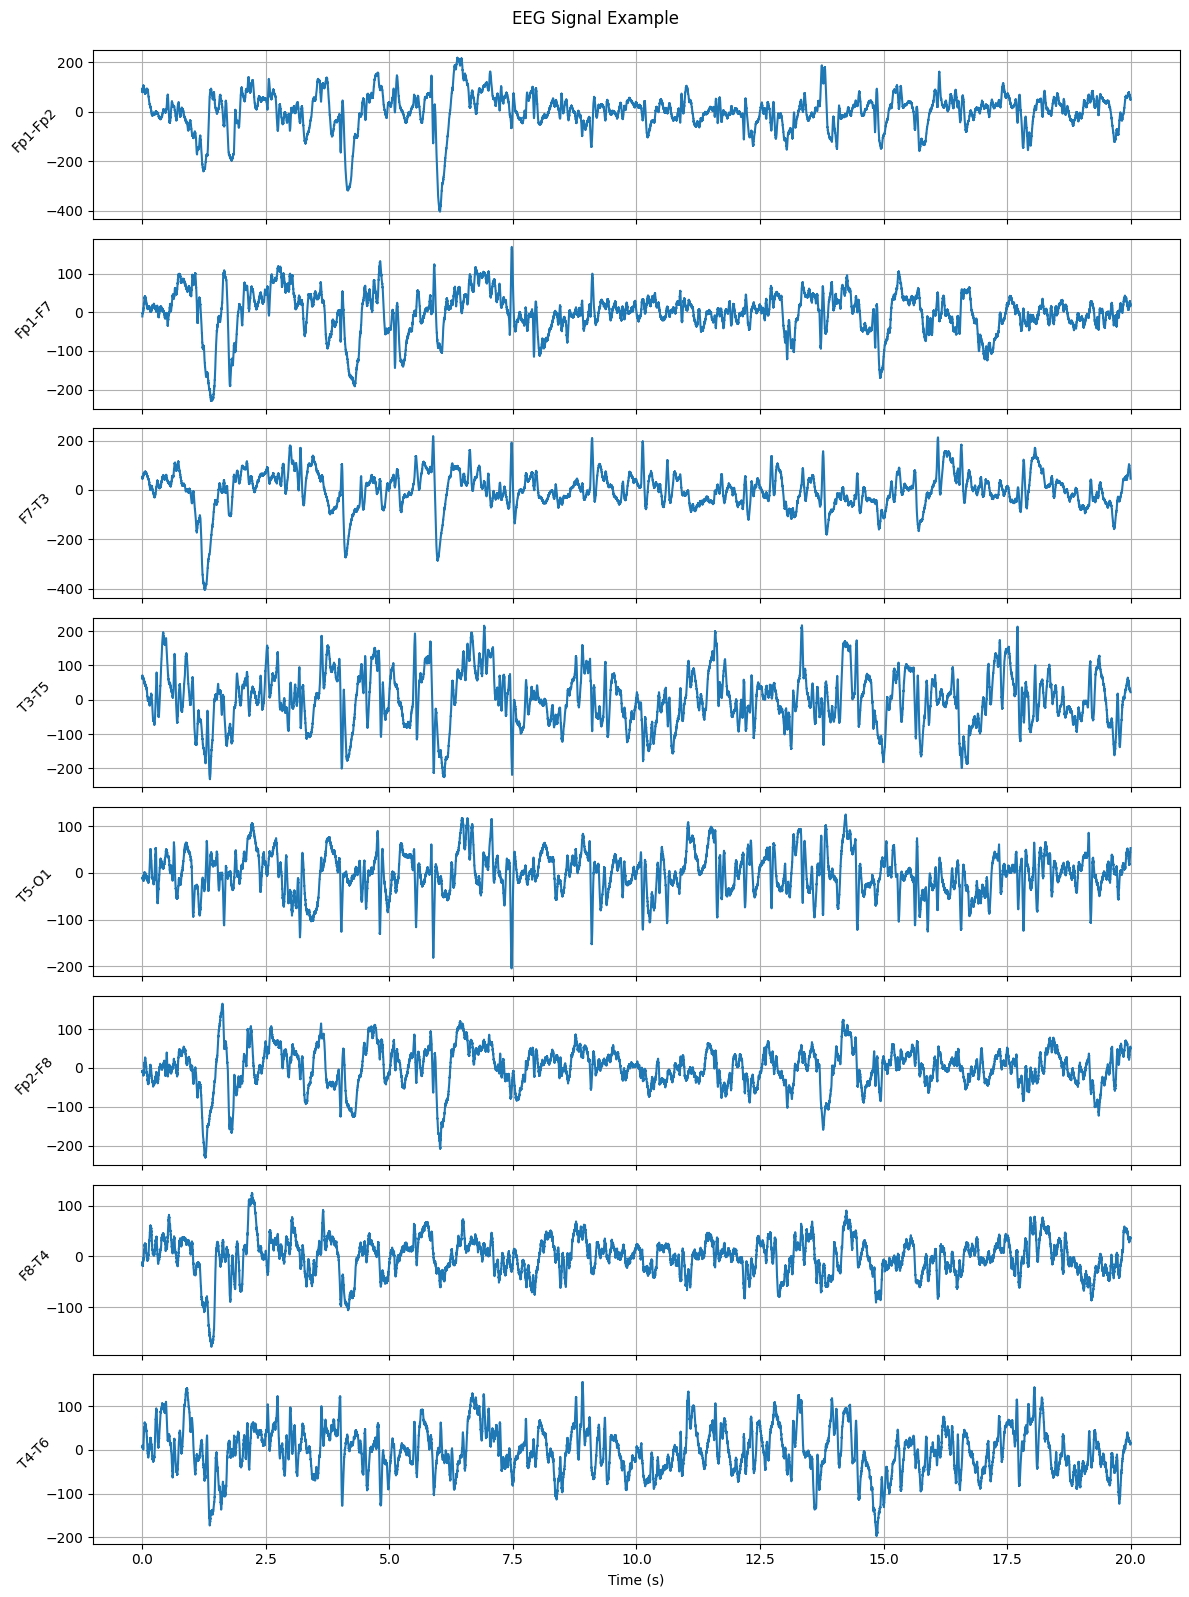

In [25]:
EvPassRejection = events[events["EvPassRejection"] == 1]  # 检测确实是癫痫的患者数据
print(EvPassRejection)

indStart = EvPassRejection["indStart"].values
indStop = EvPassRejection["indStop"].values

""" 

得重新去设计这个绘图的代码，也就是说，我的标签要和实际的EEG数据要有一个映射，但是一次性绘制多少数据呢？

"""

# 取时间长度为8秒
plot_eeg(eeg_raw.get_data(), "EEG Signal Example", ch_labels, sampling_rate=eeg_raw.info['sfreq'], start_time=0, end_time=20, target_channels=len(eeg_raw.ch_names) - 8)

# plot_eeg(eeg_raw.get_data(), "EEG Signal Example", ch_labels, sampling_rate=raw.info['sfreq'], start_time=indStart[i]/ 2000, end_time=indStop[i]/ 2000, target_channels=len(raw.ch_names) - )
# start_idx = 0 if start_time is None else max(0, int(start_time * sampling_rate))
# end_idx = n_samples if end_time is None else min(n_samples, int(end_time * sampling_rate))

# selected_data = data[1, start_idx:end_idx]


In [24]:

import matplotlib.pyplot as plt